In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import string, re
import os
import cv2 as cv

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchtext.vocab import GloVe
from torchtext.data import get_tokenizer
from torchvision.transforms import v2

In [2]:
base_path = 'pvqa/'

pvqa_dic_path = base_path + 'pvqa_dictionary.pkl'
test_img_id2idx_path = base_path + 'test_img_id2idx.pkl'
train_img_id2idx_path = base_path + 'train_img_id2idx.pkl'
val_img_id2idx_path = base_path + 'val_img_id2idx.pkl'

pvqa_dic_pkl = pd.read_pickle(pvqa_dic_path)
test_img_id2idx_pkl = pd.read_pickle(test_img_id2idx_path)
train_img_id2idx_pkl = pd.read_pickle(train_img_id2idx_path)
val_img_id2idx_pkl = pd.read_pickle(val_img_id2idx_path)

In [3]:
qas_base_path = base_path + 'qas/'

q2a_path = qas_base_path + 'q2a.pkl'
ans2lbl_path = qas_base_path + 'ans2label.pkl'
qid2a_path = qas_base_path + 'qid2a.pkl'
qid2q_path = qas_base_path + 'qid2q.pkl'
test_vqa_path = qas_base_path + 'test_vqa.pkl'
train_vqa_path = qas_base_path + 'train_vqa.pkl'
val_vqa_path = qas_base_path + 'val_vqa.pkl'
train_qa_path = qas_base_path + 'train/train_qa.pkl'
trainval_ans2lbl_path = qas_base_path + 'trainval_ans2label.pkl'
trainval_lbl2ans_path = qas_base_path + 'trainval_label2ans.pkl'

q2a_pairs = pd.read_pickle(q2a_path)
ans2lbl_pairs = pd.read_pickle(ans2lbl_path)
qid2a_pairs = pd.read_pickle(qid2a_path)
qid2q_pairs = pd.read_pickle(qid2q_path)
test_vqa_pairs = pd.read_pickle(test_vqa_path)
train_vqa_pairs = pd.read_pickle(train_vqa_path)
train_qa_pairs = pd.read_pickle(train_qa_path)
val_vqa_pairs = pd.read_pickle(val_vqa_path)
trainval_lbl2ans_pairs = pd.read_pickle(trainval_lbl2ans_path)
trainval_ans2lbl_pairs = pd.read_pickle(trainval_ans2lbl_path)

In [4]:
train_vqa_df = pd.DataFrame(train_vqa_pairs)
val_vqa_df = pd.DataFrame(val_vqa_pairs)
test_vqa_df = pd.DataFrame(test_vqa_pairs)

In [5]:
test_vqa_df

,answer_type,img_id,label,question_id,question_type,sent
0,other,test_0167,{'the histone subunits': 1},300167000,what,"What are positively charged, thus allowing th..."
1,other,test_0167,{'positively charged': 1},300167001,how,How are the histone subunits charged?
2,yes/no,test_0167,{'yes': 1},300167002,are,"Are the histone subunits positively charged, ..."
3,other,test_0099,{'the principal cellular alterations that char...,300099000,what,What are illustrated?
4,yes/no,test_0099,{'yes': 1},300099001,are,Are the principal cellular alterations that ch...
...,...,...,...,...,...,...
6756,other,test_0648,{'kidney': 1},300648002,what,What is present?
6757,yes/no,test_0648,{'yes': 1},300648003,is,Is kidney present?
6758,other,test_0648,{'sarcoidosis': 1},300648004,what,What is present?
6759,yes/no,test_0648,{'yes': 1},300648005,is,Is sarcoidosis present?


In [6]:
len(pvqa_dic_pkl[0])

4631

In [7]:
train_vqa_df

,answer_type,img_id,label,question_id,question_type,sent
0,other,train_0422,{'in the canals of hering': 1},100422000,where,Where are liver stem cells (oval cells) located?
1,other,train_0422,{'bile duct cells and canals of hering': 1},100422001,what,What are stained here with an immunohistochemi...
2,other,train_0422,{'an immunohistochemical stain': 1},100422002,what,What are bile duct cells and canals of Hering ...
3,yes/no,train_0422,{'yes': 1},100422003,are,Are bile duct cells and canals of Hering stain...
4,other,train_0986,{'an infarct in the brain': 1},100986000,what,What shows dissolution of the tissue?
...,...,...,...,...,...,...
19750,other,train_2794,{'urinary': 1},102794003,where,Where is this?
19751,other,train_2584,{'polyarteritis nodosa': 1},102584000,what,What does this image show?
19752,yes/no,train_2584,{'yes': 1},102584001,does,"Does this image show polyarteritis nodosa, kid..."
19753,yes/no,train_2584,{'no': 1},102584002,does,"Does cytomegaly show polyarteritis nodosa, kid..."


In [8]:
val_vqa_df

,answer_type,img_id,label,question_id,question_type,sent
0,other,val_0261,{'neutrophils': 1},200261000,what,What have lost their nuclei?
1,other,val_0261,{'neutrophils': 1},200261001,whose,Whose nuclei have been lost?
2,other,val_0261,{'their': 1},200261002,two,Two have lost whose nuclei ?
3,other,val_0178,{'the embolus': 1},200178000,what,What is composed of hematopoietic marrow and m...
4,other,val_0178,{'hematopoietic marrow and marrow fat cells': 1},200178001,what,What is the embolus composed of?
...,...,...,...,...,...,...
6274,other,val_0919,{'urinary': 1},200919005,where,Where is this?
6275,other,val_0849,{'polyarteritis nodosa': 1},200849000,what,What does this image show?
6276,yes/no,val_0849,{'yes': 1},200849001,does,"Does this image show polyarteritis nodosa, kid..."
6277,yes/no,val_0849,{'no': 1},200849002,does,Does metastatic carcinoma lung show polyarteri...


In [9]:
tr_q = list(train_vqa_df['sent'])
val_q = list(val_vqa_df['sent'])
ts_q = list(test_vqa_df['sent'])

tr_a = [q2a_pairs[each] for each in tr_q]
val_a = [q2a_pairs[each] for each in val_q]
ts_a = [q2a_pairs[each] for each in ts_q]

In [10]:
print(len(set(tr_a)))
print(len(set(val_a)))
print(len(set(ts_a)))

1935
681
737


In [11]:
nltk.download('stopwords')
sw_nltk = stopwords.words('english')
tokenizer = get_tokenizer("basic_english")

texts = [tr_q, ts_q, val_q]

for each in texts:
    for i in range(len(each)):
        tmp = each[i].lower()
        tmp = tokenizer(tmp)
        each[i] = [token for token in tmp if token not in string.punctuation]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\moham\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
val_lens = [len(each) for each in val_q]
tr_lens = [len(each) for each in tr_q]
ts_lens = [len(each) for each in ts_q]

print('Question with maximum length in validation set:', max(val_lens))
print('Question with minimum length in validation set:', min(val_lens))
print('Question with maximum length in training set:', max(tr_lens))
print('Question with minimum length in training set:', min(tr_lens))
print('Question with maximum length in test set:', max(ts_lens))
print('Question with minimum length in test set:', min(ts_lens))


Question with maximum length in validation set: 37
Question with minimum length in validation set: 2
Question with maximum length in training set: 37
Question with minimum length in training set: 2
Question with maximum length in test set: 36
Question with minimum length in test set: 2


In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

MAX_LEN = 37 
BATCH_SIZE = 100
ans2lbl_len = 4092
idx = 0
ans2lbl_keys = list(ans2lbl_pairs.keys())

texts = [tr_a, val_a, ts_a]

for each in texts:
	for i in range(len(each)):
		if each[i] not in ans2lbl_keys:
			ans2lbl_pairs[each[i]] = ans2lbl_len + idx
			idx += 1

In [14]:
len(list(ans2lbl_pairs.keys()))

4645

In [15]:
dfs = [train_vqa_df, val_vqa_df, test_vqa_df]
texts = [tr_a, val_a, ts_a]

for i in range(len(dfs)):
    dfs[i]['question'] = dfs[i]['sent']
    dfs[i]['answer'] = pd.Series(texts[i])
    dfs[i]['label'] = pd.Series([ans2lbl_pairs[each] for each in texts[i]])
    dfs[i].drop(['sent', 'answer_type', 'question_id', 'question_type'], axis=1, inplace=True)

In [16]:
train_vqa_df

,img_id,label,question,answer
0,train_0422,0,Where are liver stem cells (oval cells) located?,in the canals of hering
1,train_0422,1,What are stained here with an immunohistochemi...,bile duct cells and canals of hering
2,train_0422,2,What are bile duct cells and canals of Hering ...,an immunohistochemical stain
3,train_0422,3,Are bile duct cells and canals of Hering stain...,yes
4,train_0986,4,What shows dissolution of the tissue?,an infarct in the brain
...,...,...,...,...
19750,train_2794,3203,Where is this?,urinary
19751,train_2584,7822,What does this image show?,giant cells and fibrosis
19752,train_2584,3,"Does this image show polyarteritis nodosa, kid...",yes
19753,train_2584,6,"Does cytomegaly show polyarteritis nodosa, kid...",no


In [17]:
test_vqa_df

,img_id,label,question,answer
0,test_0167,6595,"What are positively charged, thus allowing th...",the histone subunits
1,test_0167,6596,How are the histone subunits charged?,positively charged
2,test_0167,3,"Are the histone subunits positively charged, ...",yes
3,test_0099,6606,What are illustrated?,the cellular alterations in apoptosis are illu...
4,test_0099,3,Are the principal cellular alterations that ch...,yes
...,...,...,...,...
6756,test_0648,2513,What is present?,sarcoidosis
6757,test_0648,3,Is kidney present?,yes
6758,test_0648,2513,What is present?,sarcoidosis
6759,test_0648,3,Is sarcoidosis present?,yes


In [18]:
val_vqa_df

,img_id,label,question,answer
0,val_0261,1282,What have lost their nuclei?,neutrophils
1,val_0261,1282,Whose nuclei have been lost?,neutrophils
2,val_0261,36,Two have lost whose nuclei ?,their
3,val_0178,3273,What is composed of hematopoietic marrow and m...,the embolus
4,val_0178,3274,What is the embolus composed of?,hematopoietic marrow and marrow fat cells
...,...,...,...,...
6274,val_0919,3203,Where is this?,urinary
6275,val_0849,7822,What does this image show?,giant cells and fibrosis
6276,val_0849,3,"Does this image show polyarteritis nodosa, kid...",yes
6277,val_0849,6,Does metastatic carcinoma lung show polyarteri...,no


In [19]:
word2ids = pvqa_dic_pkl[0]
keys = ['<oov>'] + list(word2ids.keys())
vals = list(word2ids.values())
vals = [1] + [each + 2 for each in vals]
word2ids = dict(zip(keys, vals))

texts = [tr_q, val_q, ts_q]

for each in texts:
    for i in range(len(each)):
        tmp = [] 
        
        for j in range(len(each[i])):
            if each[i][j] not in list(word2ids.keys()):
                tmp.append(word2ids['<oov>'])
            else:
                tmp.append(word2ids[each[i][j]])
                
        each[i] = tmp

for each in texts:
    for i in range(len(each)):
        for j in range(MAX_LEN - len(each[i])):
            each[i].append(0)
        each[i] = torch.tensor(each[i], dtype=torch.long)


In [20]:
EMBEDDING_DIM = 100

tr_txt = torch.zeros((len(tr_q), EMBEDDING_DIM))
val_txt = torch.zeros((len(val_q), EMBEDDING_DIM))
ts_txt = torch.zeros((len(ts_q), EMBEDDING_DIM))

tensors = [tr_txt, val_txt, ts_txt]

glove= GloVe(name='6B', dim=EMBEDDING_DIM)
emb = torch.nn.Embedding.from_pretrained(glove.vectors, freeze=True)


for i in range(len(texts)):
    for j in range(len(texts[i])):
        tmp = emb(texts[i][j])
        tmp = torch.mean(tmp, dim=0)
        tensors[i][j] = tmp


In [21]:
tr_lbl = torch.tensor(train_vqa_df['label']).to(device).long()
val_lbl = torch.tensor(val_vqa_df['label']).to(device).long()
ts_lbl = torch.tensor(test_vqa_df['label']).to(device).long()

In [22]:
# txt_encoder = nn.LSTM(EMBEDDING_DIM, 512, 2, batch_first=True)

In [23]:
# x, y = next(iter(tr_loader))
# ls = txt_encoder(x)

In [24]:
# ls[1][1].shape

In [25]:
tr_path = 'pvqa/images/train/'
val_path = 'pvqa/images/val/'
ts_path = 'pvqa/images/test/'

tr_items = os.listdir(tr_path)
ts_items = os.listdir(ts_path)
val_items = os.listdir(val_path)

tr_items = [tr_path + each for each in tr_items]
ts_items = [ts_path + each for each in ts_items]
val_items = [val_path + each for each in val_items]

img_addrs = [tr_items, val_items, ts_items]

In [26]:
max_img_dim = 0
sizes = []

for each in img_addrs:
    for each_addr in each:
        h, w, _ = cv.imread(each_addr).shape
        sizes.append((h, w))

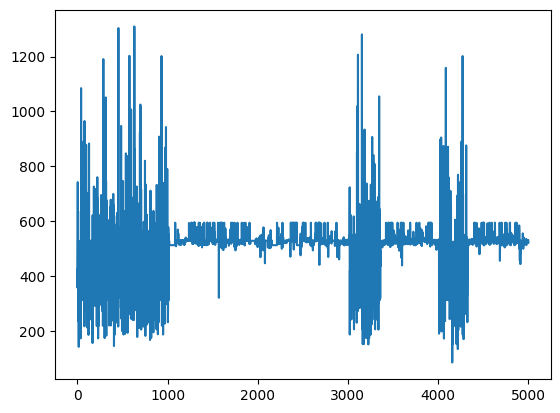

In [27]:
hs = [each[0] for each in sizes]
ws = [each[1] for each in sizes]

plt.plot(hs)

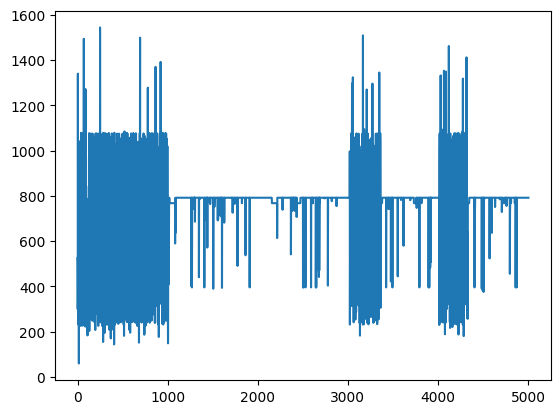

In [28]:
plt.plot(ws)

In [29]:
img_dim = 100
affine_transfomer = v2.RandomAffine(degrees=(30, 60), scale=(0.5, 0.75), shear=(30, 60))
imgs_tensors = [0, 1, 2]

for i, each_path in enumerate(img_addrs):
    imgs = []
    for addr in each_path:
        tmp = cv.cvtColor(cv.imread(addr), cv.COLOR_BGR2GRAY)
        tmp = cv.resize(tmp, (img_dim, img_dim))
        tmp = tmp.reshape((1, tmp.shape[0], tmp.shape[0]))
        tmp = np.array(affine_transfomer(torch.from_numpy(tmp)))
        imgs.append(tmp)
    imgs_tensors[i] = torch.from_numpy(np.array(imgs)).to(device)

tr_imgs, val_imgs, ts_imgs = imgs_tensors[0] / 255, imgs_tensors[1] / 255, imgs_tensors[2] / 255
del imgs_tensors

In [30]:
print('Shape of train tensor:', tr_imgs.shape)
print('Shape of validation tensor:', val_imgs.shape)
print('Shape of test tensor:', ts_imgs.shape)

Shape of train tensor: torch.Size([3021, 1, 100, 100])
Shape of validation tensor: torch.Size([992, 1, 100, 100])
Shape of test tensor: torch.Size([991, 1, 100, 100])


In [32]:
tr_img_ids = train_vqa_df['img_id'].tolist()
val_img_ids = val_vqa_df['img_id'].tolist()
ts_img_ids = test_vqa_df['img_id'].tolist()

tr_img_ids = [train_img_id2idx_pkl[each] for each in tr_img_ids]
val_img_ids = [val_img_id2idx_pkl[each] for each in val_img_ids]
ts_img_ids = [test_img_id2idx_pkl[each] for each in ts_img_ids]

train_imgs = [tr_imgs[each] for each in tr_img_ids]
validation_imgs = [val_imgs[each] for each in val_img_ids]
test_imgs = [ts_imgs[each] for each in ts_img_ids]

In [33]:
tr_loader = DataLoader(list(zip(train_imgs, tr_txt, tr_lbl)), shuffle=True, batch_size=BATCH_SIZE)
val_loader = DataLoader(list(zip(validation_imgs, val_txt, val_lbl)), shuffle=True, batch_size=BATCH_SIZE)
ts_loader = DataLoader(list(zip(test_imgs, ts_txt, ts_lbl)), shuffle=True, batch_size=BATCH_SIZE)